In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Polygon
import re

# Compute average bandwidth (given measured data)

In [190]:
dat_folder = 'data/edge/'
files = ['edge_' + str(i) + '.log' for i in range(20,160,20)]
avg_bandwidth = 0
n = 0
pattern = r'\((\d+(?:\.\d+)?),(\d+(?:\.\d+)?)\)'
for file in files:
    with open(dat_folder + file, "r") as to_read:
        for l in to_read.readlines():
            if '-' not in l:
                values = re.findall(pattern, l)
                values = [float(num) for pair in values for num in pair]
                avg_bandwidth += values[1] / values[0]
                n += 1
avg_bandwidth = (avg_bandwidth * 10**-3) / n


# Delays

In [191]:
dat_folder = 'data/'
theoretical_bandwidth = 3.75 * 10**7 #byte/s
cloud_files = ['cloud/cloud_' + str(i) + '.log' for i in range(20,160,20)]
edge_files = ['edge/edge_' + str(i) + '.log' for i in range(20,160,20)]

clouds = {}
edges = {}

pattern = r'\((\d+(?:\.\d+)?),(\d+(?:\.\d+)?)\)'

for file in cloud_files:
    scenario = file.split('_')[1][:-4]
    clouds[scenario] = []
    with open(dat_folder + file, "r") as to_read:
        for l in to_read.readlines():
            if '-' not in l:
                values = re.findall(pattern, l)
                values = [float(num) for pair in values for num in pair]
                clouds[scenario] += [values[1] / values[0]]

                
for file in edge_files:
    scenario = file.split('_')[1][:-4]
    edges[scenario] = []
    with open(dat_folder + file, "r") as to_read:
        for l in to_read.readlines():
            if '-' not in l:
                values = re.findall(pattern, l)
                values = [float(num) for pair in values for num in pair]
                edges[scenario] += [values[1] / values[0]]
                
df_clouds = pd.DataFrame(clouds).mean()
df_edges = pd.DataFrame(edges).mean()
ratio = df_edges/df_clouds

                
print(df_clouds)
print(df_edges)
print(ratio.mean()) #SLOWDOWN FACTOR OF CLOUD W.R.T. EDGE

20       949.832185
40      2993.546074
60      5455.239492
80      7529.297207
100     9275.280016
120    10555.726714
140    11549.831008
dtype: float64
20      6229.654131
40     18583.837656
60     32003.484684
80     41861.247174
100    50265.722367
120    57043.015471
140    51973.993123
dtype: float64
5.645183579750308


# Extract data for plot (no probabilistic delay)

In [166]:
dat_folder = 'data/'
files = ['3-pipelines-byte-policy.txt', '3-pipelines-latency-policy.txt']
scenarios = list(map(lambda x : x.split('.')[0], files))
n_pipelines = 3
header = ['latency', 'size', "zone"]
column_names = ["Latency (ms)","Size (MB)", "Zone"]
data = {}
dfs_dict = {}
pattern = r'\((\d+(?:\.\d+)?),(\d+(?:\.\d+)?)\)'
zone_pattern = r"\[zone:(\w+)\]"




for i in range(0,len(files)): 
    run = [[] for _ in range(0,n_pipelines)]
    data[scenarios[i]] = []
    with open(dat_folder + files[i], "r") as to_read:
        for l in to_read.readlines():
            values = re.findall(pattern, l)
            values = [[float(num) for num in pair] for pair in values]
            zones = re.findall(zone_pattern,l)
            for j in range(0,len(values)):
                lat,size = values[j][0],values[j][1] 
                zone = zones[j]
                run[j] += [(lat,size,zone)]
        data[scenarios[i]] += [run]

for scenario in scenarios:
    df_scenario = []
    for run in data[scenario]:
        df_run = []
        for pipeline_data in run:
            df_run += [pd.DataFrame(pipeline_data, columns=column_names)]
        df_scenario = df_run
    dfs_dict[scenario] = df_scenario


# Migration (no probabilistic delay)

    Latency (ms)  Size (MB)   Zone
0            0.0        0.0  cloud
1         2800.0       22.4  cloud
2          500.0       22.4   edge
3         1950.0       12.6  cloud
4         1950.0       12.6  cloud
5          200.0        1.4   edge
6         1100.0        1.4  cloud
7         7300.0       68.6  cloud
8         1300.0       68.6   edge
9         2800.0       22.4  cloud
10         500.0       22.4   edge
11        1950.0       12.6  cloud
12        1950.0       12.6  cloud
13         300.0        5.6   edge
14        1650.0        5.6  cloud
15        4750.0       50.4  cloud
16         850.0       50.4   edge


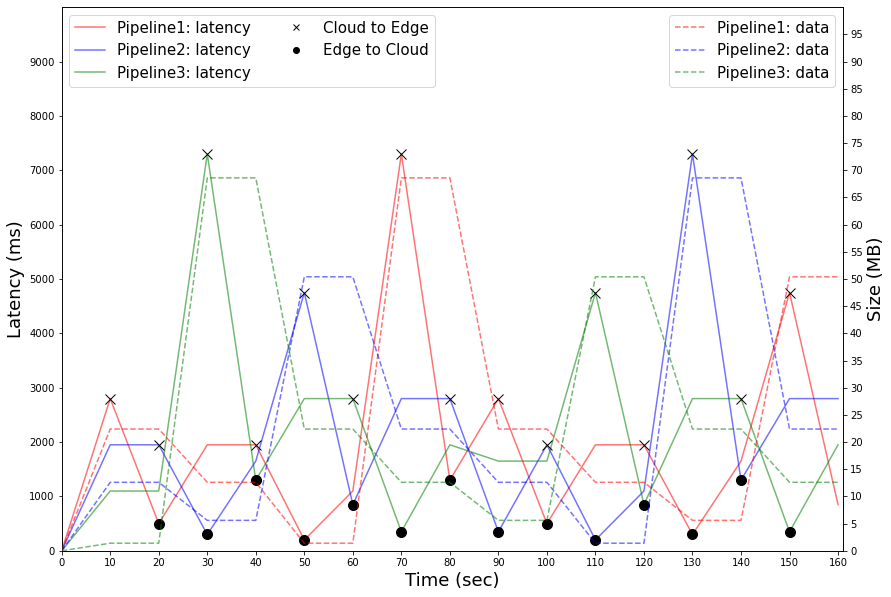

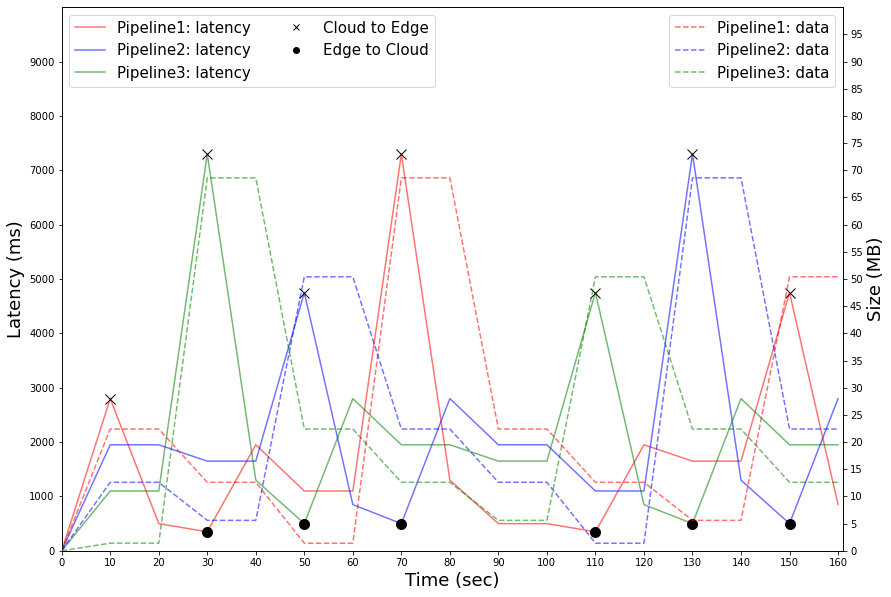

In [167]:
scenarios = ['3-pipelines-latency-policy', '3-pipelines-byte-policy']

print(dfs_dict[scenario][0])

x = [i*10 for i in range(0,len(dfs_dict[scenario][0]['Size (MB)']))]
swaps = {}

for scenario in scenarios:
    p1_byte = dfs_dict[scenario][0]['Size (MB)']
    p2_byte = dfs_dict[scenario][1]['Size (MB)']
    p3_byte = dfs_dict[scenario][2]['Size (MB)']
    p1_lat = dfs_dict[scenario][0]['Latency (ms)']
    p2_lat = dfs_dict[scenario][1]['Latency (ms)']
    p3_lat = dfs_dict[scenario][2]['Latency (ms)']
    
    swaps[scenario] = [0 for _ in range(0,n_pipelines)]

    fig = plt.figure(figsize=[14,10])
    ax = plt.subplot(111)
    ax_background = ax.twinx()
    ax.grid(False)
    ax_background.grid(False)

    # # define background plot for bytes
    b1 = ax_background.plot(
        x,
        p1_byte, 
        linestyle='dashed', 
        label='Pipeline1: data', 
        color='red', 
        zorder=100, 
        alpha=.55
    )

    b2 = ax_background.plot(
        x,
        p2_byte, 
        linestyle='dashed', 
        label='Pipeline2: data', 
        color='blue', 
        zorder=100, 
        alpha=.55
    )

    b3 = ax_background.plot(
        x,
        p3_byte, 
        linestyle='dashed', 
        label='Pipeline3: data', 
        color='green', 
        zorder=100, 
        alpha=.55
    )


    # #####latency#####

    l1 = ax.plot(
        x,
        p1_lat, 
        linestyle='solid', 
        label='Pipeline1: latency', 
        color='red', 
        zorder=1, 
        alpha=.55
    )

    l2 = ax.plot(
        x,
        p2_lat, 
        linestyle='solid', 
        label='Pipeline2: latency', 
        color='blue', 
        zorder=1, 
        alpha=.55
    )

    l3 = ax.plot(
        x,
        p3_lat, 
        linestyle='solid', 
        label='Pipeline3: latency', 
        color='green', 
        zorder=1, 
        alpha=.55
    )
    
    
    ###swap points#####

    # x (cloud -> edge) o (edge -> cloud)
    ms = 7
    pipeline_index = 0
    for pipeline in dfs_dict[scenario]:
        last_zone = 'cloud'
        for i in range(0,len(pipeline)):
            curr_zone = pipeline['Zone'][i]
            if(curr_zone != last_zone):
                swaps[scenario][pipeline_index] +=  1
                lat = pipeline['Latency (ms)'][i-1]
                ax.plot(x[i-1], lat, linewidth=100000, marker= "x" if curr_zone == "edge" else "o", markersize=ms+3, markeredgecolor="black", markerfacecolor="black", zorder=10000)
                last_zone = curr_zone
        pipeline_index += 1
    ax.plot([],[],'x',label="Cloud to Edge", color='black')
    ax.plot([],[],'o',label="Edge to Cloud", color='black')

    
    
    
    # set ticks and labels
    ax.set_xlabel('Time (sec)', fontsize=18)


    # background ticks and labels
    ax.set_yticks(range(0, 10000, 1000))
    ax_background.set_yticks(range(0, 100, 5))
    ax.set_ylim(-.0001, 10000)
    ax_background.set_ylim(-.0001, 100)
    ax.set_ylabel('Latency (ms)', fontsize=18)
    ax_background.set_ylabel('Size (MB)', fontsize=18)
    ax.set_xlim(0, 161)
    ax.set_xticks(range(0, 161, 10))

    # legend settings
    ax.legend(loc='upper left', ncol=2, frameon=True, fontsize=15)
    
    ax_background.legend(loc='upper right', ncol=1, frameon=True, fontsize=15)
    
    fig.savefig(f'images/{scenario}.pdf', dpi=100)

In [168]:
for scenario in scenarios:
    print("###" + scenario + "###")
    mean_area = 0
    mean_lat = 0
    for i in range(0,len(dfs_dict[scenario])):
        area = np.trapz(dfs_dict[scenario][i]['Latency (ms)'], dx=5)
        avg_lat = sum(dfs_dict[scenario][i]['Latency (ms)'] / len(dfs_dict[scenario][i]['Latency (ms)']))
        mean_lat += avg_lat
        mean_area += area
        print("PIPELINE " + str(i) + " AUC = " + str(area) + ", AVG Latency = " + str(avg_lat) + ", SWAPS = " + str(swaps[scenario][i]))

    print("MEAN AUC: " + str(mean_area / len(dfs_dict[scenario])) + ", MEAN AVG = " + str(mean_lat / len(dfs_dict[scenario])))
    

###3-pipelines-latency-policy###
PIPELINE 0 AUC = 157125.0, AVG Latency = 1873.529411764706, SWAPS = 11
PIPELINE 1 AUC = 167250.0, AVG Latency = 2050.0, SWAPS = 10
PIPELINE 2 AUC = 172625.0, AVG Latency = 2088.2352941176473, SWAPS = 8
MEAN AUC: 165666.66666666666, MEAN AVG = 2003.921568627451
###3-pipelines-byte-policy###
PIPELINE 0 AUC = 140875.0, AVG Latency = 1682.3529411764705, SWAPS = 5
PIPELINE 1 AUC = 163500.0, AVG Latency = 2005.8823529411768, SWAPS = 4
PIPELINE 2 AUC = 165625.0, AVG Latency = 2005.8823529411768, SWAPS = 4
MEAN AUC: 156666.66666666666, MEAN AVG = 1898.0392156862747


# Extract Birex data for plot (probabilistic delay)

In [169]:
dat_folder = 'data/'
files = ['birex-byte-policy-20runs.txt', 'birex-latency-policy-20runs.txt']
scenarios = list(map(lambda x : x.split('.')[0], files))
n_pipelines = 3
header = ['latency', 'size', "zone"]
column_names = ["Latency (ms)","Size (MB)", "Zone"]
data = {}
dfs_dict = {}
pattern = r'\((\d+(?:\.\d+)?),(\d+(?:\.\d+)?)\)'
zone_pattern = r"\[zone:(\w+)\]"


swaps_dict = {}


for i in range(0,len(files)): 
    run = [[] for _ in range(0,n_pipelines)]
    scenario = scenarios[i]
    swaps_dict[scenario] = [0 for _ in range(0,n_pipelines)]
    last = ['cloud' for _ in range(0,n_pipelines)]
    data[scenario] = []
    with open(dat_folder + files[i], "r") as to_read:
        for l in to_read.readlines():
            if '-------' in l:
                last = ['cloud' for _ in range(0,n_pipelines)]
                data[scenarios[i]] += [run]
                run = [[] for _ in range(0,n_pipelines)]
            elif 'Time' in l: pass
            else:
                values = re.findall(pattern, l)
                values = [[float(num) for num in pair] for pair in values]
                zones = re.findall(zone_pattern,l)
                for j in range(0,len(values)):
                    lat,size = values[j][0],values[j][1] 
                    zone = zones[j]
                    if zone != last[j]:
                        swaps_dict[scenario][j] += 1
                        last[j] = zone
                    if 'birex' in scenarios[i]: size /= 10**6
                    run[j] += [(lat,size,zone)]
                
for scenario in scenarios:
    df_scenario = []
    for run in data[scenario]:
        df_run = []
        for pipeline_data in run:
            df_run += [pd.DataFrame(pipeline_data, columns=column_names)]
        df_scenario += [df_run]
    dfs_dict[scenario] = df_scenario

averages_dict = {}

for scenario in scenarios:
    averages_dict[scenario] = []
    for i in range(n_pipelines):
        p = [run[i] for run in dfs_dict[scenario]]  
        averages_dict[scenario] += [pd.concat(p).groupby(level=0).mean()]

avg_swaps_dict = {}
for scenario in swaps_dict:
    avg_swaps_dict[scenario] = [value / len(dfs_dict[scenario]) for value in swaps_dict[scenario]]
    


# Plot (Average behaviour of n runs)

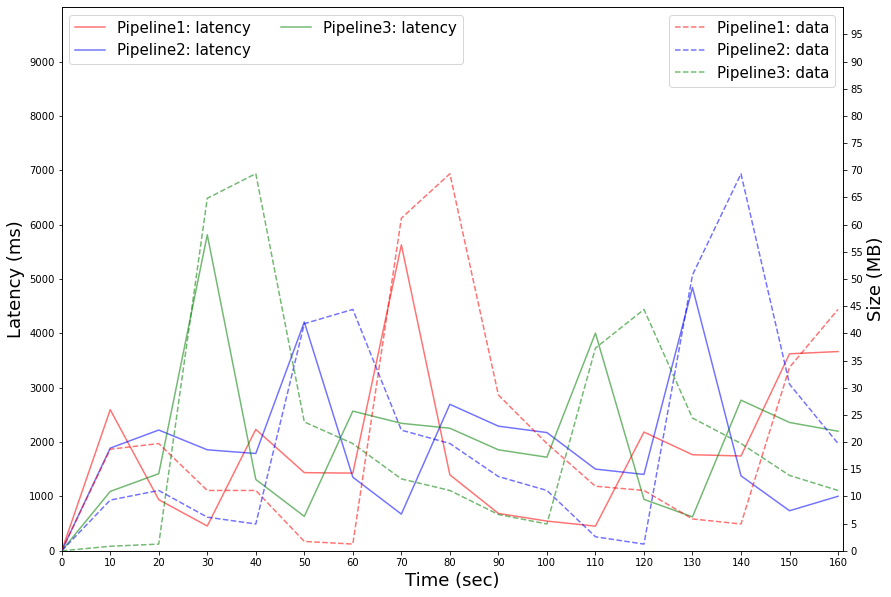

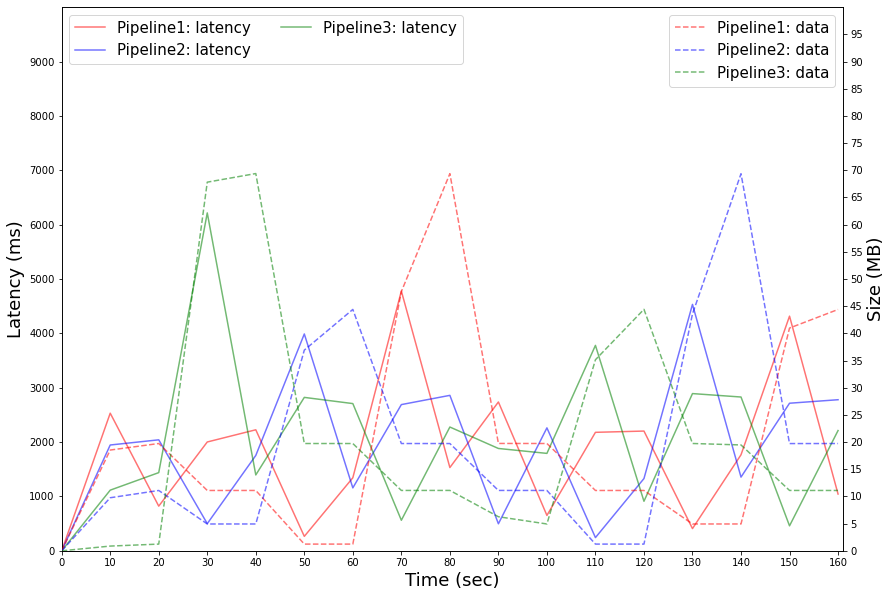

In [170]:
x = [i*10 for i in range(0,len(averages_dict[scenario][0]['Size (MB)']))]
swaps = {}

for scenario in scenarios:
    p1_byte = averages_dict[scenario][0]['Size (MB)']
    p2_byte = averages_dict[scenario][1]['Size (MB)']
    p3_byte = averages_dict[scenario][2]['Size (MB)']
    p1_lat = averages_dict[scenario][0]['Latency (ms)']
    p2_lat = averages_dict[scenario][1]['Latency (ms)']
    p3_lat = averages_dict[scenario][2]['Latency (ms)']
    
    fig = plt.figure(figsize=[14,10])
    ax = plt.subplot(111)
    ax_background = ax.twinx()
    ax.grid(False)
    ax_background.grid(False)
    
    # # define background plot for bytes
    b1 = ax_background.plot(
        x,
        p1_byte, 
        linestyle='dashed', 
        label='Pipeline1: data', 
        color='red', 
        zorder=100, 
        alpha=.55
    )

    b2 = ax_background.plot(
        x,
        p2_byte, 
        linestyle='dashed', 
        label='Pipeline2: data', 
        color='blue', 
        zorder=100, 
        alpha=.55
    )

    b3 = ax_background.plot(
        x,
        p3_byte, 
        linestyle='dashed', 
        label='Pipeline3: data', 
        color='green', 
        zorder=100, 
        alpha=.55
    )


    # #####latency#####

    l1 = ax.plot(
        x,
        p1_lat, 
        linestyle='solid', 
        label='Pipeline1: latency', 
        color='red', 
        zorder=1, 
        alpha=.55
    )

    l2 = ax.plot(
        x,
        p2_lat, 
        linestyle='solid', 
        label='Pipeline2: latency', 
        color='blue', 
        zorder=1, 
        alpha=.55
    )

    l3 = ax.plot(
        x,
        p3_lat, 
        linestyle='solid', 
        label='Pipeline3: latency', 
        color='green', 
        zorder=1, 
        alpha=.55
    )
    
        
    
    
    # set ticks and labels
    ax.set_xlabel('Time (sec)', fontsize=18)


    # background ticks and labels
    ax.set_yticks(range(0, 10000, 1000))
    ax_background.set_yticks(range(0, 100, 5))
    ax.set_ylim(-.0001, 10000)
    ax_background.set_ylim(-.0001, 100)
    ax.set_ylabel('Latency (ms)', fontsize=18)
    ax_background.set_ylabel('Size (MB)', fontsize=18)
    ax.set_xlim(0, 161)
    ax.set_xticks(range(0, 161, 10))

    # legend settings
    ax.legend(loc='upper left', ncol=2, frameon=True, fontsize=15)
    
    ax_background.legend(loc='upper right', ncol=1, frameon=True, fontsize=15)
    
    fig.savefig(f'images/{scenario}.pdf', dpi=100)

# Extract Single Pipeline Data

In [171]:
dat_folder = 'data/'
files = ['birex-1pipeline.txt']
scenarios = list(map(lambda x : x.split('.')[0], files))
n_pipelines = 1
header = ['latency', 'size', "zone"]
column_names = ["Latency (ms)","Size (MB)", "Zone"]
data = {}
pattern = r'\((\d+(?:\.\d+)?),(\d+(?:\.\d+)?)\)'
zone_pattern = r'\b(cloud|edge)\b'



for i in range(0,len(files)): 
    run = [[]]
    data[scenarios[i]] = []
    with open(dat_folder + files[i], "r") as to_read:
        for l in to_read.readlines():
            if '-------' in l:
                data[scenarios[i]] += [run]
                run = [[]]
            elif 'Time' in l: pass
            else:
                values = re.findall(pattern, l)
                values = [[float(num) for num in pair] for pair in values]
                zones = re.findall(zone_pattern,l)
                lat,size = values[0][0],values[0][1] 
                zone = zones[0]
                size /= 10**6
                run[0] += [(lat,size,zone)]


for scenario in scenarios:
    df_scenario = []
    for run in data[scenario]:
        df_run = []
        for pipeline_data in run:
            df_run += [pd.DataFrame(pipeline_data, columns=column_names)]
        df_scenario += [df_run]
    dfs_dict[scenario] = df_scenario




# Extract Error Probability

In [206]:
sizes = [[80, 60, 20, 140, 80, 60, 40, 120], [60, 40, 120, 80, 60, 20, 140, 80], [20, 140, 80, 60, 40, 120, 80, 60]]
errors = {20:0, 40:0, 60:0, 80:0, 120:0, 140:0}
total = {20:0, 40:0, 60:0, 80:0, 120:0, 140:0}

files = ['birex-1pipeline.txt', 'birex-byte-policy-20runs.txt', 'birex-latency-policy-20runs.txt']
scenarios = list(map(lambda x : x.split('.')[0], files))
threshold = 0.6

for scenario in scenarios:
    dfs = dfs_dict[scenario]
    print(scenario + " " + str(len(dfs)))
    for df_list in dfs:
        pipeline_index = 0
        for pipeline in df_list:
            s_index = 0
            for i, r in pipeline.iterrows():
                if i > s_index:
                    prev = pipeline['Size (MB)'][i-1]
                    v = r['Size (MB)']
                    l = r['Latency (ms)']
                    z = r['Zone']
                    s_id = sizes[pipeline_index][(s_index//2)]
                    total[s_id] += 1
                    t_size = (10**-6) * header_size * s_id ** 2
                    diff = abs(v - t_size)
                    err =  diff / t_size
                    s_index += 1
                    #print(z + " " + str(s_id) + " " + str(v) + " " + str(t_size) + " err: " + str(err > .2 and diff > threshold))
                    if err > .2 and diff > threshold: #an error is considered as something that makes the behaviour of the system diverge, e.g. the simulation swaps the real-world implementation does not
                        errors[s_id] += 1
            pipeline_index += 1
            #print("-----")
        #print("---end run---")
result = {key: round(100*errors[key] / total[key], 3) for key in total.keys() if key in total}

print("errors----------->" + str(errors))
print("total------------>" + str(total))
print("error %---------->" + str(result))


#sizes = [[80, 60, 20, 140, 80, 60, 40, 120], [60, 40, 120, 80, 60, 20, 140, 80], [20, 140, 80, 60, 40, 120, 80, 60]];



birex-1pipeline 40
birex-byte-policy-20runs 25
birex-latency-policy-20runs 22
errors----------->{20: 17, 40: 26, 60: 30, 80: 83, 120: 78, 140: 79}
total------------>{20: 362, 40: 362, 60: 724, 80: 724, 120: 362, 140: 362}
error %---------->{20: 4.696, 40: 7.182, 60: 4.144, 80: 11.464, 120: 21.547, 140: 21.823}


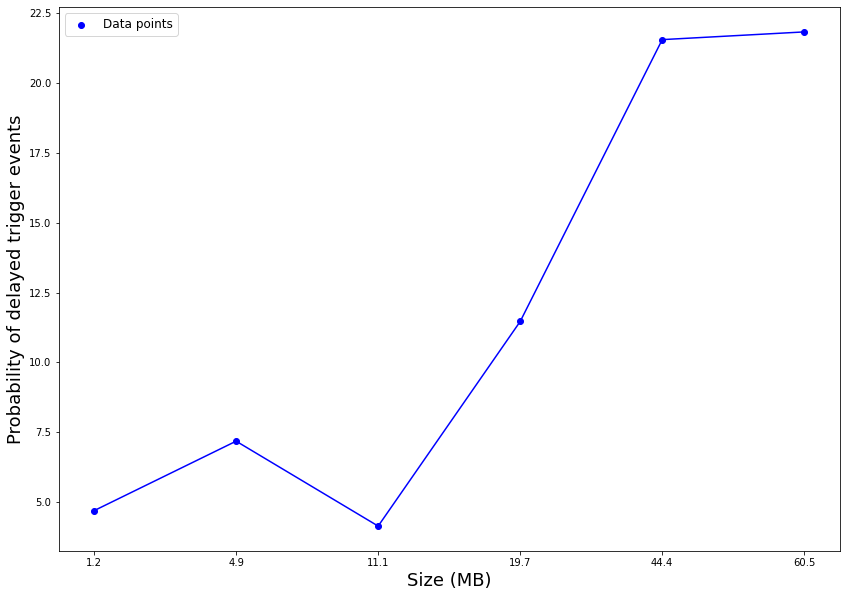

In [207]:
x = ['1.2', '4.9', '11.1', '19.7', '44.4', '60.5']
y = list(result.values()) 

fig = plt.figure(figsize=(14, 10))

plt.scatter(x, y, color='blue', label='Data points')
plt.plot(x, y, color='blue') 

plt.legend(loc='upper left', fontsize=12)

plt.xlabel('Size (MB)', fontsize=18)
plt.ylabel('Probability of delayed trigger events', fontsize=18)
plt.grid(False)
plt.show()

fig.savefig(f'images/err_distribution.pdf', dpi=100)
#fig.savefig(f'../phd-thesis/figures/err_distribution.pdf', dpi=100)

# Extract the function to approximate the graph

In [203]:
# Extract x and y values
x_values = np.array(list(result.keys()))
y_values = np.array(list(result.values()))

# Fit a polynomial to the data
coefficients = np.polyfit(x_values, y_values, 5)
f = np.poly1d(coefficients)

# Print the polynomial function
print(f)

           5             4            3          2
5.634e-08 x - 2.319e-05 x + 0.003505 x - 0.2361 x + 6.981 x - 64.99


# Extract ABS data for plot (probabilistic delay)

In [157]:
dat_folder = 'data/'
files = ['3-pipelines-size-policy_with_error.txt']
scenarios = list(map(lambda x : x.split('.')[0], files))
n_pipelines = 3
header = ['latency', 'size', "zone"]
column_names = ["Latency (ms)","Size (MB)", "Zone"]
data = {}
dfs_dict = {}
pattern = r'\((\d+(?:\.\d+)?),(\d+(?:\.\d+)?)\)'
zone_pattern = r"\[zone:(\w+)\]"


swaps_dict = {}

for i in range(0,len(files)): 
    scenario = scenarios[i]
    run = [[] for _ in range(0,n_pipelines)]
    data[scenario] = []
    swaps_dict[scenario] = [0 for _ in range(0,n_pipelines)]
    last = ['cloud' for _ in range(0,n_pipelines)]
    with open(dat_folder + files[i], "r") as to_read:
        for l in to_read.readlines():
            if '-------' in l:
                last = ['cloud' for _ in range(0,n_pipelines)]
                data[scenarios[i]] += [run]
                run = [[] for _ in range(0,n_pipelines)]
            elif 'Time' in l: pass
            else:
                values = re.findall(pattern, l)
                values = [[float(num) for num in pair] for pair in values]
                zones = re.findall(zone_pattern,l)
                for j in range(0,len(values)):
                    lat,size = values[j][0],values[j][1] 
                    zone = zones[j]
                    if zone != last[j]:
                        swaps_dict[scenario][j] += 1
                        last[j] = zone
                    run[j] += [(lat,size,zone)]
                
for scenario in scenarios:
    df_scenario = []
    for run in data[scenario]:
        df_run = []
        for pipeline_data in run:
            df_run += [pd.DataFrame(pipeline_data, columns=column_names)]
        df_scenario += [df_run]
    dfs_dict[scenario] = df_scenario

averages_dict = {}

for scenario in scenarios:
    averages_dict[scenario] = []
    for i in range(n_pipelines):
        p = [run[i] for run in dfs_dict[scenario]]  
        averages_dict[scenario] += [pd.concat(p).groupby(level=0).mean()]


for scenario in swaps_dict:
    avg_swaps_dict[scenario] = [value / len(dfs_dict[scenario]) for value in swaps_dict[scenario]]
    
    
print(avg_swaps_dict)

{'birex-byte-policy-20runs': [4.2, 3.2, 4.0], 'birex-latency-policy-20runs': [11.0, 10.0, 8.0], '3-pipelines-size-policy_with_error': [4.64, 3.64, 4.0]}


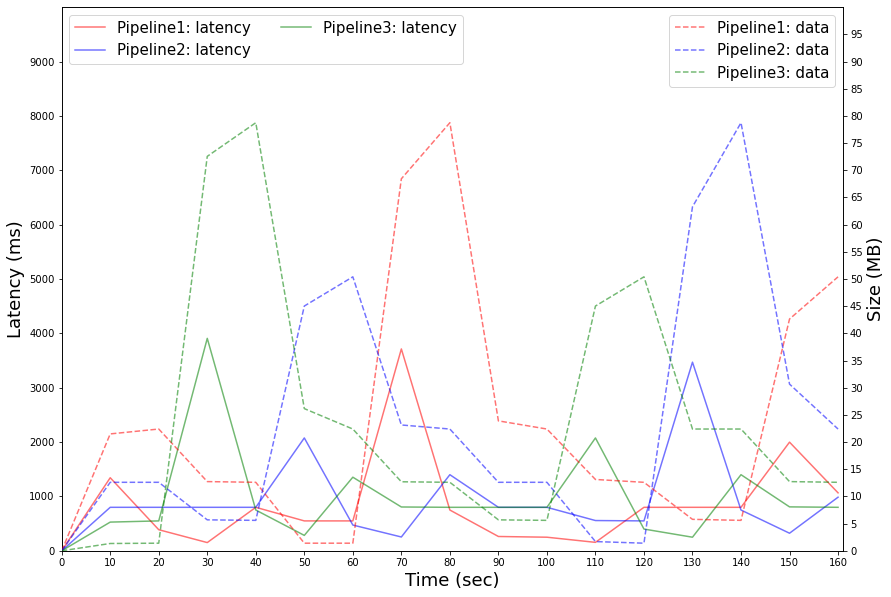

In [158]:
x = [i*10 for i in range(0,len(averages_dict[scenario][0]['Size (MB)']))]
swaps = {}

for scenario in scenarios:
    p1_byte = averages_dict[scenario][0]['Size (MB)']
    p2_byte = averages_dict[scenario][1]['Size (MB)']
    p3_byte = averages_dict[scenario][2]['Size (MB)']
    p1_lat = averages_dict[scenario][0]['Latency (ms)']
    p2_lat = averages_dict[scenario][1]['Latency (ms)']
    p3_lat = averages_dict[scenario][2]['Latency (ms)']
    
    fig = plt.figure(figsize=[14,10])
    ax = plt.subplot(111)
    ax_background = ax.twinx()
    ax.grid(False)
    ax_background.grid(False)
    
    # # define background plot for bytes
    b1 = ax_background.plot(
        x,
        p1_byte, 
        linestyle='dashed', 
        label='Pipeline1: data', 
        color='red', 
        zorder=100, 
        alpha=.55
    )

    b2 = ax_background.plot(
        x,
        p2_byte, 
        linestyle='dashed', 
        label='Pipeline2: data', 
        color='blue', 
        zorder=100, 
        alpha=.55
    )

    b3 = ax_background.plot(
        x,
        p3_byte, 
        linestyle='dashed', 
        label='Pipeline3: data', 
        color='green', 
        zorder=100, 
        alpha=.55
    )


    # #####latency#####

    l1 = ax.plot(
        x,
        p1_lat, 
        linestyle='solid', 
        label='Pipeline1: latency', 
        color='red', 
        zorder=1, 
        alpha=.55
    )

    l2 = ax.plot(
        x,
        p2_lat, 
        linestyle='solid', 
        label='Pipeline2: latency', 
        color='blue', 
        zorder=1, 
        alpha=.55
    )

    l3 = ax.plot(
        x,
        p3_lat, 
        linestyle='solid', 
        label='Pipeline3: latency', 
        color='green', 
        zorder=1, 
        alpha=.55
    )
    
        
    
    
    # set ticks and labels
    ax.set_xlabel('Time (sec)', fontsize=18)


    # background ticks and labels
    ax.set_yticks(range(0, 10000, 1000))
    ax_background.set_yticks(range(0, 100, 5))
    ax.set_ylim(-.0001, 10000)
    ax_background.set_ylim(-.0001, 100)
    ax.set_ylabel('Latency (ms)', fontsize=18)
    ax_background.set_ylabel('Size (MB)', fontsize=18)
    ax.set_xlim(0, 161)
    ax.set_xticks(range(0, 161, 10))

    # legend settings
    ax.legend(loc='upper left', ncol=2, frameon=True, fontsize=15)
    
    ax_background.legend(loc='upper right', ncol=1, frameon=True, fontsize=15)
    
    fig.savefig(f'images/{scenario}.pdf', dpi=100)
    #fig.savefig(f'../phd-thesis/figures/{scenario}.pdf', dpi=100)